In [1]:
from google.colab import files

uploaded = files.upload()

Saving train_data.csv to train_data.csv


In [2]:
import pandas as pd
df = pd.read_csv('train_data.csv', sep=';')

In [ ]:
!pip install xgboost


In [3]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X = df.drop(['was_alarm_event'], axis=1)
y = df['was_alarm_event']

In [4]:
X = X.drop(columns=['Unnamed: 0'], axis=1)

In [5]:
X.columns

Index(['day_datetime_timestamp', 'day_tempmax', 'day_tempmin', 'day_temp',
       'hour_temp', 'day_dew', 'day_humidity', 'day_precip', 'hour_precipprob',
       'day_precipcover', 'hour_snow', 'hour_windgust', 'hour_windspeed',
       'hour_winddir', 'hour_pressure', 'hour_cloudcover', 'hour_visibility',
       'day_solarradiation', 'day_solarenergy', 'day_uvindex', 'day_sunrise',
       'day_sunset', 'day_moonphase', 'weather_Clear', 'russian', 'ukrainian',
       'forces', 'ukraine', 'russia', 'oblast', 'military', 'operations',
       'offensive', 'bakhmut', 'likely', 'war', 'defense', 'reported',
       'claimed', 'stated', 'continued', 'kremlin', 'putin', 'wagner',
       'president', 'general', 'city', 'donetsk', 'western'],
      dtype='object')

In [7]:
class_counts = y.value_counts()


print("розподіл")
print(y.value_counts(normalize=True) * 100)


розподіл
was_alarm_event
0    71.646954
1    28.353046
Name: proportion, dtype: float64


SMOTE

In [8]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

X_resampled, y_resampled = smote.fit_resample(X, y)

print(y_resampled.value_counts())


was_alarm_event
1    502852
0    502852
Name: count, dtype: int64


In [9]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

model = xgb.XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor', gpu_id=0)

param_dist = {
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [0.8, 1.0, 1.2]
}

random_search = RandomizedSearchCV(model, param_distributions=param_dist,
                                   n_iter=50, scoring='accuracy', n_jobs=-1, cv=3, verbose=2)

random_search.fit(X_train, y_train)


y_pred = random_search.best_estimator_.predict(X_test)

print(classification_report(y_test, y_pred))



Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:52:36] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:52:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:52:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not u

              precision    recall  f1-score   support

           0       0.86      0.87      0.87    100858
           1       0.87      0.86      0.86    100283

    accuracy                           0.87    201141
   macro avg       0.87      0.87      0.87    201141
weighted avg       0.87      0.87      0.87    201141



In [21]:
import joblib

joblib.dump(random_search.best_estimator_, 'XGB_F.pkl')


['XGB_F.pkl']

In [22]:
from google.colab import files

files.download('XGB_F.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

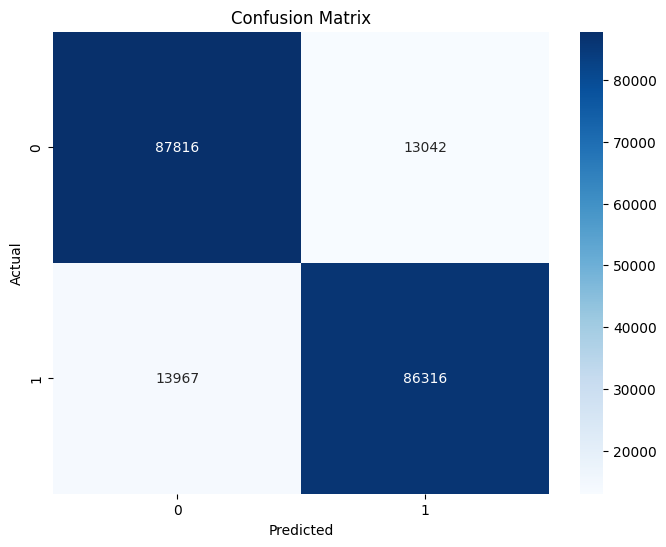

In [10]:
conf_mat = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


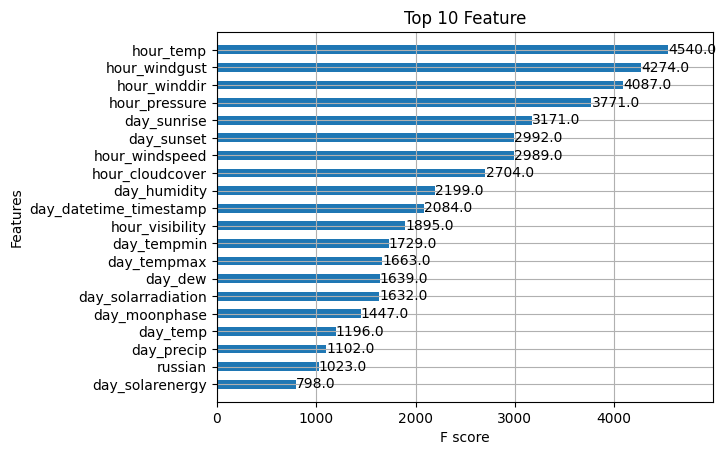

In [18]:
best_model = random_search.best_estimator_
xgb.plot_importance(best_model, importance_type='weight', max_num_features=20, height=0.5)
plt.title("Top 20 фіч")
plt.show()